In [1]:
MAIN_PATH = "/home/carlos/MasterDS/tfm"
JSON_DATA_PATH = '{}/data/json/'.format(MAIN_PATH)
CSV_DATA_PATH = '{}/data/csv/'.format(MAIN_PATH)

In [2]:
import sys
sys.path.insert(0, MAIN_PATH)

In [3]:
import torch
cuda = torch.device('cuda')

In [4]:
%load_ext autoreload
%autoreload 2
from scripts.models.ltr_svm_tf.train import LTRSVMTFTrain
from scripts.models.ltr_svm_tf.metrics import LTRSVMTFMetrics

%reload_ext autoreload

# Entrenamiento

In [5]:
ltr_params = {
    'mode': 'tfidf',
    'count_vec_kwargs': {'strip_accents': 'unicode'},
    'target_metric': 'cosine_emb',
    'metric_params': {'embedding': 'distilroberta-base-paraphrase-v1',
                     'text_process': 'basic'},
    'drop_teams': True,
    'lemma': True,
    'train_perc': 0.7,
    'val_perc': 0.2
}

dim_reduction_params = {
    'dim_reduction': 'truncated_svd',
    'dim_reduction_params': {
        'n_components': 20,
        'random_state': 10
    }
}

model_params = {}

In [6]:
ltr_train = LTRSVMTFTrain(model_params=model_params, ltr_params=ltr_params,
                         dim_reduction_params=dim_reduction_params)

Setting target metric to cosine_emb
Setting mode to tfidf
Using truncated_svd for dimensionality reduction


In [7]:
ltr_train.config()

{'cv': 0,
 'opt_metric': '',
 'mode': 'tfidf',
 'count_vec_kwargs': {'strip_accents': 'unicode'},
 'target_metric': 'cosine_emb',
 'metric_params': {'embedding': 'distilroberta-base-paraphrase-v1',
  'text_process': 'basic'},
 'drop_teams': True,
 'lemma': True,
 'train_perc': 0.7,
 'val_perc': 0.2,
 'dim_reduction': 'truncated_svd',
 'dim_reduction_params': {'n_components': 250, 'random_state': 10}}

In [13]:
X_train, y_train = ltr_train.train_data()

Loading training data from /home/carlos/MasterDS/tfm/data/ltr/features_targets/c04dabab1a


In [12]:
X_train.shape

(339040, 6550)

In [13]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [7]:
pipe = ltr_train.pipeline()

In [8]:
pipe

Pipeline(steps=[('dim_reduction',
                 TruncatedSVD(n_components=20, random_state=10)),
                ('model', SVR())])

In [38]:
svd = pipe['dim_reduction']

In [39]:
svd

TruncatedSVD(n_components=100, random_state=10)

In [40]:
svd.fit(X_train)

TruncatedSVD(n_components=100, random_state=10)

In [32]:
print(svd.explained_variance_ratio_)

[0.02235638 0.04210266 0.01812384 0.01580045 0.01313825 0.01410513
 0.01334876 0.01266    0.01031466 0.00943746 0.00714626 0.00691487
 0.00629958 0.00586444 0.00449015 0.00395849 0.0036879  0.00342522
 0.00331367 0.00330109]


In [41]:
print(svd.explained_variance_ratio_.sum())

0.3666228741949588


Probamos distintos valores para ver cuanta varianza podemos capturar:

In [11]:
from sklearn.decomposition import TruncatedSVD

In [10]:
n_components_list = [20, 50, 100, 250]

In [14]:
explained_variances = list()
for n in n_components_list:
    print(n)
    svd = TruncatedSVD(n_components=n, random_state=10)
    print('Training svd...')
    svd = svd.fit(X_train)
    explained_variances.append((n, svd.explained_variance_ratio_.sum()))

20
Training svd...
50
Training svd...
100
Training svd...
250
Training svd...


Con 250 componentes se explica cerca del 50% de la varianza. Si 
ponemos más componentes casca por tamaño (la salida es una matriz densa)

In [15]:
explained_variances

[(20, 0.21978926148589364),
 (50, 0.2883908028467658),
 (100, 0.3666228741949588),
 (250, 0.519955898198082)]

In [16]:
svd = TruncatedSVD(n_components=20, random_state=10)
svd = svd.fit(X_train)

In [17]:
X_train_tra = svd.transform(X_train)

In [18]:
X_train_tra

array([[ 3.43874398e-01, -2.32942369e-01,  1.98446714e-07, ...,
        -4.84087814e-02, -2.26805458e-02,  1.13433472e-01],
       [ 2.01745808e-01,  2.98098643e-01, -3.69591577e-08, ...,
        -1.08689428e-02, -1.74352421e-02, -2.26900103e-02],
       [ 3.75387637e-02, -2.47268085e-02,  1.70828083e-07, ...,
        -3.71039512e-02, -3.20342542e-02,  5.73265652e-03],
       ...,
       [ 2.07892441e-01,  3.12139384e-01, -8.10199924e-09, ...,
        -1.02181457e-03,  4.57877857e-03,  2.29267605e-02],
       [ 4.94864576e-03,  7.12811943e-04,  1.68627733e-07, ...,
        -2.07370791e-02,  1.12016390e-02, -7.12703107e-03],
       [ 1.57801917e-01,  2.35783731e-01, -7.17426905e-09, ...,
         8.52643338e-04,  1.05394340e-03,  2.36059563e-02]])

In [19]:
X_train_tra.shape

(339040, 20)

In [12]:
ltr_train.path

'/home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/90ce3442c0'

In [20]:
%%time
ltr_train.train()

Writing config in /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/config.pickle
Loading training data from /home/carlos/MasterDS/tfm/data/ltr/features_targets/c04dabab1a
Training model...
Writing model to /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/ckpt.pickle
Writing model info to /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/model_info.pickle
CPU times: user 4h 25min 59s, sys: 6.82 s, total: 4h 26min 5s
Wall time: 4h 25min 57s


## Salida

In [21]:
model = ltr_train.read_model()

In [22]:
model

Pipeline(steps=[('dim_reduction',
                 TruncatedSVD(n_components=20, random_state=10)),
                ('model', SVR())])

In [23]:
model_info = ltr_train.read_model_info()

In [24]:
model_info

{'best_score': None,
 'best_params': None,
 'model_out': {'explained_variance': 0.21978926148589364}}

## Métricas

In [7]:
ltr_metrics = LTRSVMTFMetrics(ltr_train)

In [26]:
ltr_metrics.run()

Computing metric for train dataset
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/train_metrics.pickle
Computing metric for validation dataset
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/validation_metrics.pickle
Computing metric for test dataset
Writing metrics to /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/test_metrics.pickle


Reading metrics from /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/train_metrics.pickle
mse : 0.00625296869233683
mae : 0.06228472608466589
r2 : 0.4174475091401483


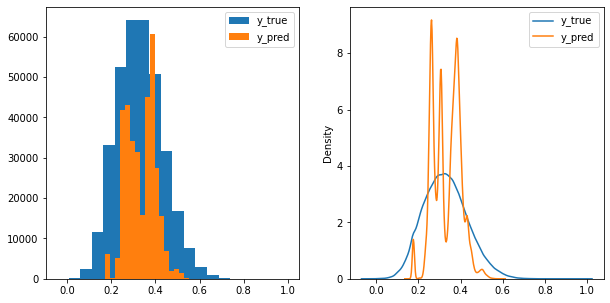

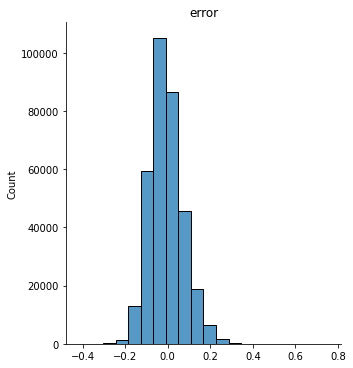

In [27]:
ltr_metrics.show_metrics('train')

Reading metrics from /home/carlos/MasterDS/tfm/models/ltr_svm_tfidf/4422e10011/validation_metrics.pickle
mse : 0.00620041730343146
mae : 0.06201236783480001
r2 : 0.42049455382634704


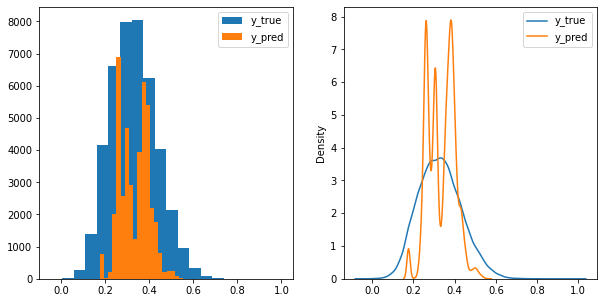

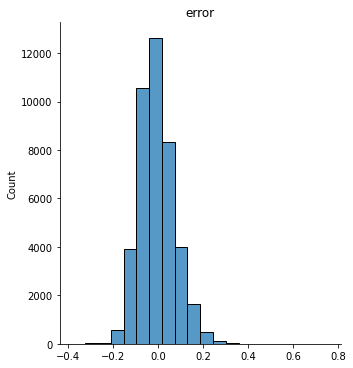

In [28]:
ltr_metrics.show_metrics('validation')